In [50]:

import numpy as np
import pandas as pd
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn import metrics
from collections import Counter
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.sklearn import metrics

#from common_utils import compute_metrics

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]



#Load the data
titanic_data = pd.read_csv('C:/Users/thano/Υπολογιστής/ΠΤΥΧΙΑΚΗ/DATASETS/titanic.csv',sep= ',', header= 0)

In [51]:
print ("Dataset Lenght:: ", len(titanic_data))
print ("Dataset Shape:: ", titanic_data.shape)
#titanic_data.sample(50)


print ("Rows     : " ,titanic_data.isnull().shape[0])
print ("Columns  : " ,titanic_data.isnull().shape[1])
print ("\nMissing values :  ", titanic_data.isnull().sum().values.sum())



Dataset Lenght::  891
Dataset Shape::  (891, 12)
Rows     :  891
Columns  :  12

Missing values :   866


In [52]:
#replace ? with NaN
titanic_data = titanic_data.replace('?', np.nan)
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [53]:
#drop the missing values
titanic_data = titanic_data.dropna()
titanic_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [ ]:
# rename the other values except class =1 value in Pclass column for SPD computation
titanic_data['Pclass']= titanic_data['Pclass'].replace([2,3], 2.3)
titanic_data.head(20)

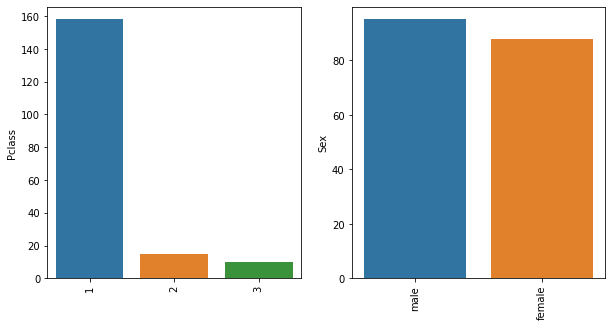

In [54]:
#plot the categorical count of each protected category
lis2 = ['Pclass', 'Sex']
plt.subplots(figsize=(10, 5))
index = 1
  
for col in lis2:
    y = titanic_data[col].value_counts()
    plt.subplot(1, 2, index)
    plt.xticks(rotation=90)
    sns.barplot(x=list(y.index), y=y)
    index += 1

In [6]:
# select all categorical variables
titanic_data_categorical = titanic_data.select_dtypes(include=['object'])
titanic_data_categorical.head()

,Name,Sex,Ticket,Cabin,Embarked
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
6,"McCarthy, Mr. Timothy J",male,17463,E46,S
10,"Sandstrom, Miss. Marguerite Rut",female,PP 9549,G6,S
11,"Bonnell, Miss. Elizabeth",female,113783,C103,S


In [7]:
# apply label encoder to categorical values
le = preprocessing.LabelEncoder()
titanic_data_categorical = titanic_data_categorical.apply(le.fit_transform)
titanic_data_categorical.head()

,Name,Sex,Ticket,Cabin,Embarked
1,49,0,109,72,0
3,70,0,31,48,2
6,112,1,55,117,2
10,148,0,120,131,2
11,27,0,26,43,2


In [8]:
#Drop earlier duplicate columns which had categorical values and concat with new labelled categories (cd function)
titanic_data = titanic_data.drop(titanic_data_categorical.columns,axis=1)
titanic_data = pd.concat([titanic_data,titanic_data_categorical],axis=1)
titanic_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Cabin,Embarked
1,2,1,1,38.0,1,0,71.2833,49,0,109,72,0
3,4,1,1,35.0,1,0,53.1000,70,0,31,48,2
6,7,0,1,54.0,0,0,51.8625,112,1,55,117,2
10,11,1,3,4.0,1,1,16.7000,148,0,120,131,2
11,12,1,1,58.0,0,0,26.5500,27,0,26,43,2


In [9]:
titanic_data1 = titanic_data.drop(['Survived'], axis=1)
titanic_data = pd.concat([titanic_data1,titanic_data['Survived']],axis=1)
#adult_data = pd.concat([adult_data,adult_data_categorical],axis=1)
titanic_data.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Cabin,Embarked,Survived
1,2,1,38.0,1,0,71.2833,49,0,109,72,0,1
3,4,1,35.0,1,0,53.1000,70,0,31,48,2,1
6,7,1,54.0,0,0,51.8625,112,1,55,117,2,0
10,11,3,4.0,1,1,16.7000,148,0,120,131,2,1
11,12,1,58.0,0,0,26.5500,27,0,26,43,2,1


KeyError: 'native.country'

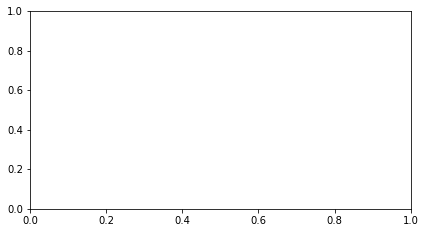

In [10]:
#plot the distributions
lis = ['native.country', 'occupation', 'workclass']
plt.subplots(figsize=(15, 8))
index = 1
  
for i in lis:
    plt.subplot(2, 2, index)
    sns.distplot(titanic_data[i])
    index += 1

In [ ]:
#Pearson correlations
pearson = titanic_data.corr(method = 'pearson')
pearson

In [ ]:
#create Heatmap 
plt.figure(figsize = (40,20))
sns.heatmap(pearson, annot = True)

In [ ]:
print(abs(pearson[['sex']]).nlargest(n=9, columns='sex'))

In [11]:
target = titanic_data.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
	per = v / len(target) * 100
	print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=1, Count=123, Percentage=67.213%
Class=0, Count=60, Percentage=32.787%


In [12]:
# convert target variable Survived to categorical
titanic_data['Survived'] = titanic_data['Survived'].astype('category')

In [ ]:
titanic_data.info()

In [ ]:
titanic_data.head()

In [13]:
#MinMax scalling
scaler = MinMaxScaler()
scaled = scaler.fit_transform(titanic_data)
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

In [15]:
#back to Dataset
titanic = pd.DataFrame(scaled,columns = titanic_data.columns)
titanic.head(30)                    

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Cabin,Embarked,Survived
0,0.000000,0.0,0.468892,0.333333,0.00,0.139136,0.269231,0.0,0.865079,0.545455,0.0,1.0
1,0.002252,0.0,0.430956,0.333333,0.00,0.103644,0.384615,0.0,0.246032,0.363636,1.0,1.0
2,0.005631,0.0,0.671219,0.000000,0.00,0.101229,0.615385,1.0,0.436508,0.886364,1.0,0.0
3,0.010135,1.0,0.038948,0.333333,0.25,0.032596,0.813187,0.0,0.952381,0.992424,1.0,1.0
4,0.011261,0.0,0.721801,0.000000,0.00,0.051822,0.148352,0.0,0.206349,0.325758,1.0,1.0
5,0.022523,0.5,0.418311,0.000000,0.00,0.025374,0.104396,1.0,0.547619,0.750000,1.0,1.0
6,0.024775,0.0,0.342438,0.000000,0.00,0.069291,0.851648,1.0,0.238095,0.075758,1.0,1.0
7,0.029279,0.0,0.228629,1.000000,0.50,0.513342,0.351648,1.0,0.500000,0.416667,1.0,0.0
8,0.057432,0.0,0.607992,0.333333,0.00,0.149765,0.450549,0.0,0.809524,0.681818,0.0,1.0
9,0.059685,0.0,0.810319,0.000000,0.25,0.120975,0.714286,1.0,0.158730,0.136364,0.0,0.0


In [17]:
titanic['Survived']= titanic['Survived'].apply(np.int64)

In [18]:
# Putting independent variables/features to X
X = titanic.drop('Survived',axis=1)
# Putting response/dependent variable/feature to y
y = titanic['Survived']


In [39]:
# Splitting the data into train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

#privileged_groups = [{'Sex' :1}]
#unprivileged_groups = [{'Sex' :0}]
privileged_groups = [{'Pclass' :0.0}]
unprivileged_groups = [{'Pclass' : 0.5 or 1.0}]

In [27]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  183 non-null    float64
 1   Pclass       183 non-null    float64
 2   Age          183 non-null    float64
 3   SibSp        183 non-null    float64
 4   Parch        183 non-null    float64
 5   Fare         183 non-null    float64
 6   Name         183 non-null    float64
 7   Sex          183 non-null    float64
 8   Ticket       183 non-null    float64
 9   Cabin        183 non-null    float64
 10  Embarked     183 non-null    float64
 11  Survived     183 non-null    int64  
dtypes: float64(11), int64(1)
memory usage: 17.3 KB


In [28]:
titanic.head(10)

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Cabin,Embarked,Survived
0,0.000000,0.0,0.468892,0.333333,0.00,0.139136,0.269231,0.0,0.865079,0.545455,0.0,1
1,0.002252,0.0,0.430956,0.333333,0.00,0.103644,0.384615,0.0,0.246032,0.363636,1.0,1
2,0.005631,0.0,0.671219,0.000000,0.00,0.101229,0.615385,1.0,0.436508,0.886364,1.0,0
3,0.010135,1.0,0.038948,0.333333,0.25,0.032596,0.813187,0.0,0.952381,0.992424,1.0,1
4,0.011261,0.0,0.721801,0.000000,0.00,0.051822,0.148352,0.0,0.206349,0.325758,1.0,1
5,0.022523,0.5,0.418311,0.000000,0.00,0.025374,0.104396,1.0,0.547619,0.750000,1.0,1
6,0.024775,0.0,0.342438,0.000000,0.00,0.069291,0.851648,1.0,0.238095,0.075758,1.0,1
7,0.029279,0.0,0.228629,1.000000,0.50,0.513342,0.351648,1.0,0.500000,0.416667,1.0,0
8,0.057432,0.0,0.607992,0.333333,0.00,0.149765,0.450549,0.0,0.809524,0.681818,0.0,1
9,0.059685,0.0,0.810319,0.000000,0.25,0.120975,0.714286,1.0,0.158730,0.136364,0.0,0


In [29]:
binaryLabelDataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df= titanic,
    label_names = ['Survived'],
    protected_attribute_names=['Pclass'])

In [30]:
#SPD without classification
metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
# Load and create explainers

text_exp_otr = MetricTextExplainer(metric_orig_train)
# Print statistical parity difference
print(text_exp_otr.statistical_parity_difference())

Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): 0.12911392405063293


In [31]:
from aif360.metrics import BinaryLabelDatasetMetric
metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Staistical Parity Difference between unprivileged and privileged groups = %f" % metric_orig_train.statistical_parity_difference())

#### Original training dataset

Staistical Parity Difference between unprivileged and privileged groups = 0.129114


In [32]:
# Fitting the decision tree with the best hyperparameters after doing GridSearch
from sklearn.model_selection import GridSearchCV
tree_param = {'criterion':['gini','entropy'],'max_depth':range(2,20)}
dt_default = GridSearchCV(DecisionTreeClassifier(), tree_param)
dt_default.fit(X_train,y_train)

print('Best score: {}'.format(dt_default.best_score_))
print('Best parameters: {}'.format(dt_default.best_params_))


Best score: 0.7505291005291005
Best parameters: {'criterion': 'gini', 'max_depth': 11}


In [33]:
#find the best parameters for the classifier and fit it to the data 
dt_best = DecisionTreeClassifier(criterion= 'gini', max_depth= 11)
dt_best.fit(X_train,y_train)
# making predictions
y_pred_default = dt_best.predict(X_test)

In [34]:
#Compute accuracy
from sklearn import metrics
accuracy_scorer = metrics.make_scorer(metrics.accuracy_score)
# Printing classifier report after prediction
print("\nAccuracy Score is: " + str(metrics.accuracy_score(y_test, y_pred_default)))


Accuracy Score is: 0.6739130434782609


In [38]:
#Print classification report and confussion matrix
print(classification_report(y_test, y_pred_default))

print(confusion_matrix(y_test, y_pred_default))

              precision    recall  f1-score   support

           0       0.50      0.67      0.57        15
           1       0.81      0.68      0.74        31

    accuracy                           0.67        46
   macro avg       0.65      0.67      0.65        46
weighted avg       0.71      0.67      0.68        46

[[10  5]
 [10 21]]


In [35]:
X_test = pd.concat([X_test,y_test],axis=1)
X_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Cabin,Embarked,Survived
142,0.786036,1.0,0.519474,0.000000,0.00,0.014932,0.516484,1.0,0.611111,0.954545,1.0,0
89,0.507883,0.0,0.367729,0.000000,0.00,0.054164,0.335165,1.0,0.119048,0.348485,0.0,0
158,0.844595,1.0,0.064239,0.000000,0.25,0.024350,0.653846,1.0,0.690476,0.803030,1.0,1
133,0.727477,0.0,0.696510,0.000000,0.00,0.069291,0.846154,1.0,0.357143,0.037879,0.0,1
172,0.925676,1.0,0.329793,0.000000,0.25,0.024350,0.659341,0.0,0.690476,0.803030,1.0,1
105,0.579955,0.5,0.418311,0.000000,0.00,0.020495,0.549451,0.0,0.722222,0.977273,1.0,1
8,0.057432,0.0,0.607992,0.333333,0.00,0.149765,0.450549,0.0,0.809524,0.681818,0.0,1
13,0.097973,0.0,0.279211,1.000000,0.50,0.513342,0.346154,0.0,0.500000,0.416667,1.0,1
124,0.684685,0.0,0.494183,0.000000,0.00,0.299539,0.824176,0.0,0.817460,0.378788,1.0,1
82,0.481982,1.0,0.393020,0.000000,0.00,0.015713,0.758242,1.0,0.984127,0.780303,1.0,1


In [36]:
binaryLabelDataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df= X_test,
    label_names=['Survived'],
    protected_attribute_names=['Pclass'])

In [37]:
from aif360.metrics import BinaryLabelDatasetMetric

def fair_metrics(binaryLabelDataset, y_pred_default):
    dataset_pred = binaryLabelDataset.copy()
    dataset_pred.labels = y_pred_default
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {'statistical_parity_difference': metric_pred.statistical_parity_difference()}
        
    return result


fair_metrics(binaryLabelDataset, y_pred_default)

{'statistical_parity_difference': -0.16025641025641024}

In [ ]:
#cross validation with 10 folds and mean accuracy 
cross_val_score(dt_best, X, y, cv = 10).mean()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
clf = DecisionTreeClassifier(criterion= 'gini', max_depth= 9).fit(X_train_transformed, y_train)
X_test_transformed = scaler.transform(X_test)
clf.score(X_test_transformed, y_test)

In [ ]:
#pipeline with Standarization, Classifier and cross validation with 10 folds
from sklearn.pipeline import make_pipeline
clf = make_pipeline(preprocessing.StandardScaler(),DecisionTreeClassifier(criterion= 'gini', max_depth= 9))
cross_val_score(clf, X, y, cv=10).mean()


In [40]:
# list of models
models = [LogisticRegression(max_iter=500), SVC(kernel='linear'), KNeighborsClassifier(), RandomForestClassifier(), GaussianNB()]

In [41]:
#function for comparing the accuracy of 4 classifiers after 10-fold cross validation
def compare_models_cross_validation():

  for model in models:

    cv_score = cross_val_score(model, X,y, cv=10)
    
    mean_accuracy = sum(cv_score)/len(cv_score)

    mean_accuracy = mean_accuracy*100

    mean_accuracy = round(mean_accuracy, 2)

    print('Cross Validation accuracies for ', model, '=  ', cv_score)
    print('Accuracy % of the ', model, mean_accuracy )
    print('----------------------------------------------')

In [42]:
#Execute the function
compare_models_cross_validation()

Cross Validation accuracies for  LogisticRegression(max_iter=500) =   [0.78947368 0.78947368 0.84210526 0.83333333 0.77777778 0.77777778
 0.66666667 0.72222222 0.83333333 0.66666667]
Accuracy % of the  LogisticRegression(max_iter=500) 76.99
----------------------------------------------
Cross Validation accuracies for  SVC(kernel='linear') =   [0.84210526 0.78947368 0.84210526 0.83333333 0.72222222 0.77777778
 0.61111111 0.66666667 0.88888889 0.66666667]
Accuracy % of the  SVC(kernel='linear') 76.4
----------------------------------------------
Cross Validation accuracies for  KNeighborsClassifier() =   [0.78947368 0.84210526 0.89473684 0.94444444 0.72222222 0.72222222
 0.72222222 0.61111111 0.66666667 0.66666667]
Accuracy % of the  KNeighborsClassifier() 75.82
----------------------------------------------
Cross Validation accuracies for  RandomForestClassifier() =   [0.31578947 0.78947368 0.84210526 0.94444444 0.72222222 0.66666667
 0.61111111 0.66666667 0.72222222 0.72222222]
Accura

In [43]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
accuracy : 0.7252747252747254



70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\thano\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\thano\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\thano\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

One or more of the test sc

In [44]:
logreg2=LogisticRegression(C=1,penalty="l2")
logreg2.fit(X_train,y_train)
print("score",logreg2.score(X_test,y_test))

score 0.8260869565217391


In [45]:
y_pred_default = logreg2.predict(X_test)

In [ ]:
#Specifity and Sensitivity
Sensitivity_recall = metrics.recall_score(y_test, y_pred_default)
Specificity =  metrics.recall_score(y_test, y_pred_default, pos_label=0)
#true negatives and true positives
tpr=np.sum((y_pred_default.ravel()==1)*(y_test.ravel()==1)) / np.sum(y_pred_default.ravel()==1)
tnr=np.sum((y_pred_default.ravel()==0)*(y_test.ravel()==0)) / np.sum(y_pred_default.ravel()==0)
#Print metrics
print({"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity})
print("True positive rate =",tpr)  
print("True negative rate =",tnr)

In [46]:
X_test = pd.concat([X_test,y_test],axis=1)
X_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Cabin,Embarked,Survived
161,0.860360,0.0,0.633283,0.333333,0.00,0.152164,0.500000,0.0,0.373016,0.621212,1.0,1
153,0.828829,0.0,0.430956,0.000000,0.00,1.000000,0.554945,1.0,0.896825,0.090909,0.0,1
141,0.784910,0.0,0.607992,0.333333,0.25,0.216430,0.934066,1.0,0.420635,0.500000,0.0,0
22,0.152027,0.0,0.228629,0.000000,0.50,0.051302,0.703297,0.0,0.269841,0.719697,1.0,1
62,0.364865,0.0,0.443601,0.000000,0.00,0.264739,1.000000,0.0,0.936508,0.431818,0.0,1
155,0.834459,0.0,0.253920,0.666667,0.50,0.512122,0.802198,0.0,0.873016,0.227273,0.0,1
99,0.557432,0.0,0.671219,0.333333,0.00,0.152766,0.324176,0.0,0.658730,0.651515,0.0,1
181,0.997748,0.0,0.228629,0.000000,0.00,0.058556,0.412088,0.0,0.079365,0.189394,1.0,1
101,0.566441,0.0,0.190693,0.000000,0.00,0.168837,0.598901,0.0,0.000000,0.272727,1.0,1
129,0.708333,0.0,1.000000,0.000000,0.00,0.058556,0.060440,1.0,0.563492,0.022727,1.0,1


In [47]:
binaryLabelDataset2 = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df= X_test,
    label_names=['Survived'],
    protected_attribute_names=['Pclass'])

In [48]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

dataset = StandardDataset(X_test, 
                          label_name='Survived', 
                          favorable_classes=[1], 
                          protected_attribute_names=['Pclass'], 
                          privileged_classes=[[1]])

def fair_metrics(dataset, y_pred_default):
    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred_default
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {'statistical_parity_difference': metric_pred.statistical_parity_difference(),
             'disparate_impact': metric_pred.disparate_impact(),
             'equal_opportunity_difference': classified_metric.equal_opportunity_difference()}
        
    return result


fair_metrics(dataset, y_pred_default)

invalid value encountered in double_scalars
invalid value encountered in double_scalars


{'statistical_parity_difference': 0.19047619047619047,
 'disparate_impact': 1.380952380952381,
 'equal_opportunity_difference': 0.3529411764705882}

In [49]:
from aif360.metrics import BinaryLabelDatasetMetric

def fair_metrics(binaryLabelDataset2, y_pred_default):
    dataset_pred = binaryLabelDataset2.copy()
    dataset_pred.labels = y_pred_default
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {'statistical_parity_difference': metric_pred.statistical_parity_difference()}
        
    return result


fair_metrics(binaryLabelDataset2, y_pred_default)

{'statistical_parity_difference': 0.19047619047619047}

In [ ]:
from aif360.metrics import BinaryLabelDatasetMetric
metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset2,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Staistical Parity Difference between unprivileged and privileged groups = %f" % metric_orig_train.statistical_parity_difference())

In [ ]:
# Printing classifier report after prediction
print("\nAccuracy Score is: " + str(metrics.accuracy_score(y_test, y_pred_default)))

In [ ]:
#function for comparing accuracy of 4 classifiers 
#test_data_prediction = []
def compare_models_train_test():

  for model in models:

    # training the model
    model.fit(X_train, y_train)
    
    # evaluating the model
    test_data_prediction = model.predict(X_test)

    accuracy = accuracy_score(y_test, test_data_prediction)

    print('Accuracy score of the ', model, ' = ', accuracy)

In [ ]:
#Execute the def
compare_models_train_test()